# Prithvi burn scars detection demo

Introducing Prithvi, an innovative temporal Vision Transformer jointly developed by the [collaborative efforts of IBM and NASA](https://www.earthdata.nasa.gov/news/impact-ibm-hls-foundation-model). This groundbreaking model was pretrained using continental US Harmonised Landsat Sentinel 2 (HLS) data. The focus of this demo is to highlight the model's refinement in detecting burn scars. Further details can be explored [here](https://huggingface.co/ibm-nasa-geospatial/Prithvi-100M-burn-scar).

To facilitate burn scar detection, users are required to provide an HLS array that encompasses the following reflectance channels (ranging from 0 to 1): Blue, Green, Red, Narrow NIR, SWIR 1, and SWIR 2.

## Methodology

This demonstration employs a fine-tuned version of the Prithvi model to identify instances of burn scars in new data presented in a numpy array format. By way of illustration, we will employ this model to detect burn scars within the [`IFArafoCandelaria` fire](https://www.copernicus.eu/en/media/image-day-gallery/ifarafocandelaria-fire-still-burning-tenerife) in Tenerife.

The input data will be retrieved from the CMR-STAC API. The process involves searching for a specific subset by defining a region of interest and a designated time frame, all of which are tailored to suit our particular use case.

- **Daily 30 meter (m) global HLS Sentinel-2 Multi-spectral Instrument Surface Reflectance - [HLSS30.002](https://doi.org/10.5067/HLS/HLSS30.002)**
    - _The HLSS30 product provides 30 m Nadir normalized Bidirectional Reflectance Distribution Function (BRDF)-Adjusted Reflectance (NBAR) and is derived from Sentinel-2A and Sentinel-2B MSI data products._  
     - **Science Dataset (SDS) layers:** 
        - B12 (SWIR 2) 
        - B12 (SWIR 1) 
        - B8A (NIR Narrow)  
        - B04 (Red)   
        - B03 (Green) 
        - B02 (Blue) 


- **Daily 30 meter (m) global HLS Landsat-8 OLI Surface Reflectance - [HLSL30.002](https://doi.org/10.5067/HLS/HLSL30.002)**
    - _The HLSL30 product provides 30 m Nadir normalized Bidirectional Reflectance Distribution Function (BRDF)-Adjusted Reflectance (NBAR) and is derived from Landsat-8 OLI data products._  
     - **Science Dataset (SDS) layers:**  
        - B07 (SWIR 2)  
        - B06 (SWIR 1)
        - B05 (NIR) 
        - B04 (Red) 
        - B03 (Green) 
        - B02 (Blue)  

## Setup

### Library import

In [24]:
import sys

# Include local library paths 
sys.path.append("../src/")

from map_interaction import LeafletMap  
from data_search import CMRSTACCatalog
from data_extraction import COGExtractor
from model_inference import ModelProcessor

## Data  acquisition
### Draw a rectangle on map to select and area

In [25]:
geometry = {'type': 'FeatureCollection',
 'features': [{'type': 'Feature',
   'properties': {},
   'geometry': {'type': 'Polygon',
    'coordinates': [[[-16.708832, 28.176139],
      [-16.708832, 28.519383],
      [-16.300964, 28.519383],
      [-16.300964, 28.176139],
      [-16.708832, 28.176139]]]}}]}

In [26]:
map = LeafletMap(geometry=geometry)
map

Draw a rectangle on map to select and area.


LeafletMap(center=[28.347760999999995, -16.504898], controls=(ZoomControl(options=['position', 'zoom_in_text',…

### Search items on the CMR-STAC API

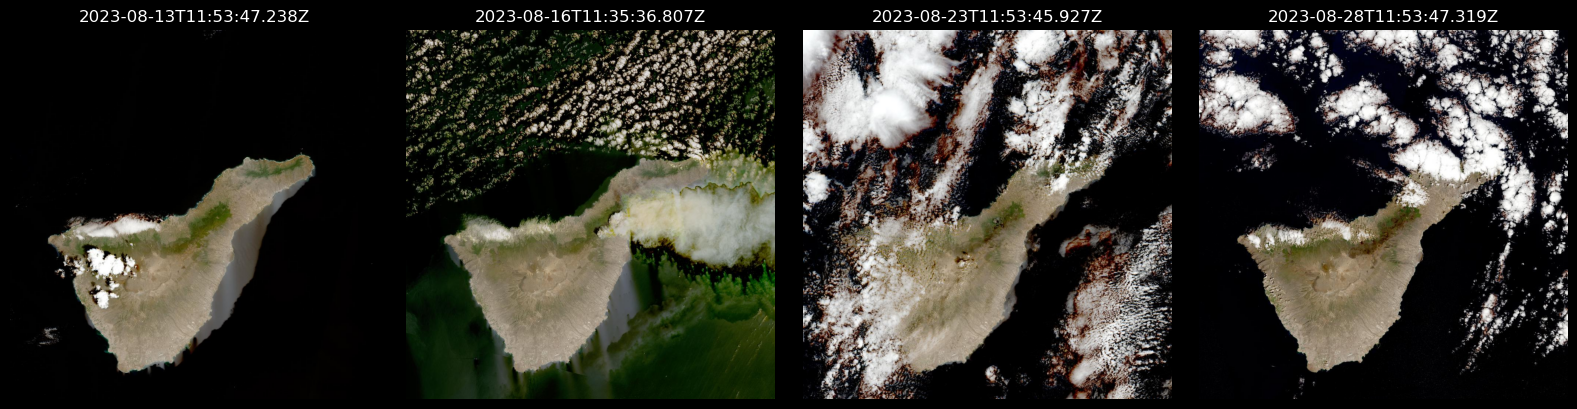

In [27]:
# Create and instance of a CMR STAC catalog
catalog = CMRSTACCatalog()

# Search for items of interest:
items = catalog.search(bbox=map.bbox, start_date=f"2023-08-13", end_date=f"2023-08-31", 
                    limit=10)
#items = catalog.search(bbox=map.bbox, start_date=f"2024-05-01", end_date=f"2024-05-10", 
#                    limit=10)

# Display RGB images of all items in a single plot
catalog.display_rgb_images(items)

### Extracting HLS COGs from the Cloud

GDAL configurations set successfully.
Authentication to NASA Earthdata Login credentials set successfully.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
/home/iker/mambaforge/envs/hls_data_project/lib/python3.11/site-packages/matplotlib/cm.py:478: RuntimeWarning: invalid value encountered in cast
  xx = (xx * 255).astype(np.uint8)


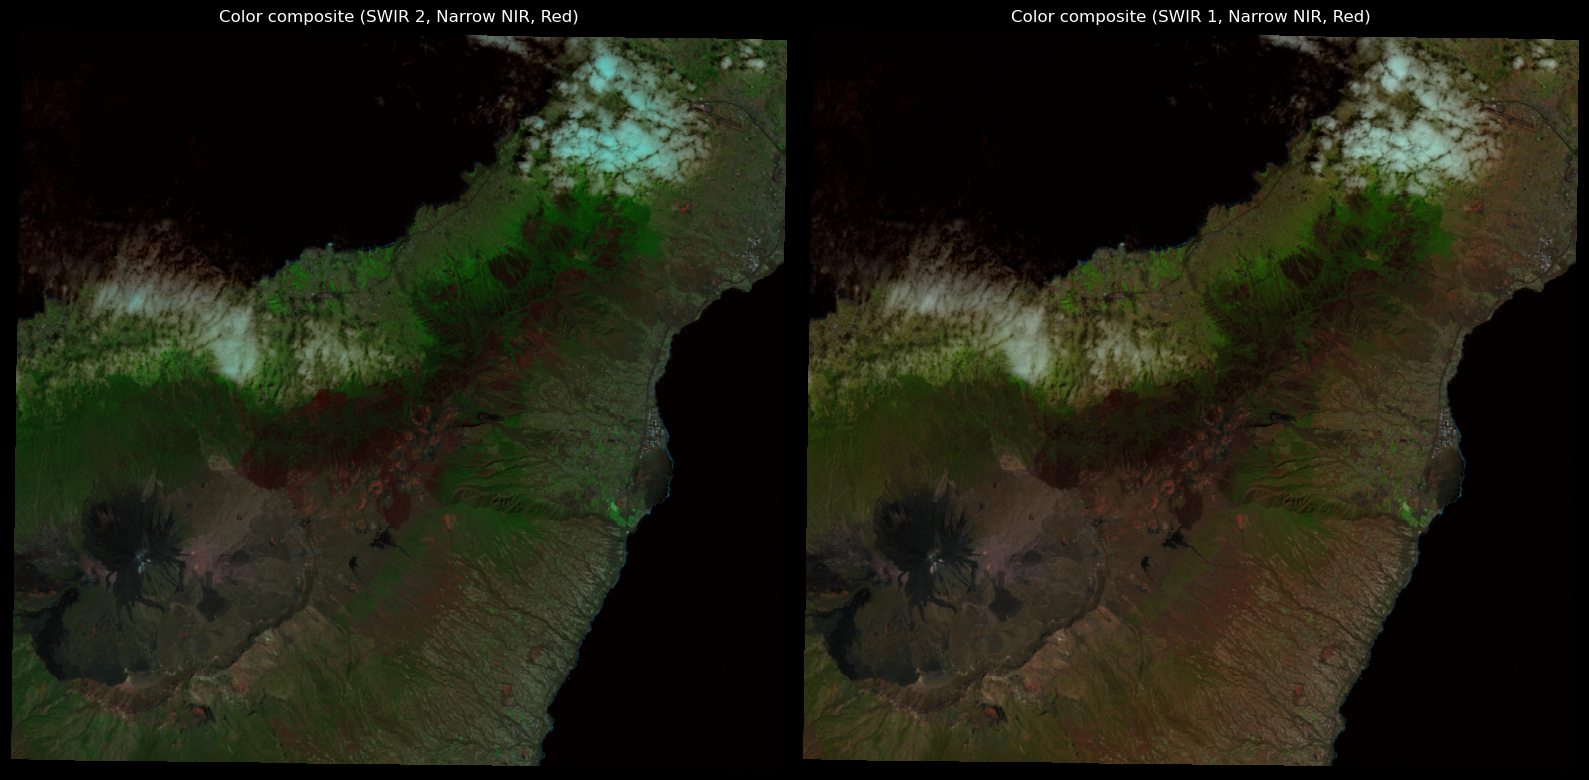

In [28]:
# Initialize COGExtractor
cog_extractor = COGExtractor(items[-1], map.polygon)  
#cog_extractor = COGExtractor(items[0], map.polygon)

# Get data
band_data = cog_extractor.get_data(normalize=True)

# Input array
input_array = cog_extractor.get_input_array(band_data)

# Display composites
cog_extractor.display_composites(band_data)

## Burn scards detection

load checkpoint from local path: ../Prithvi/checkpoints/burn_scars_Prithvi_100M.pth


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


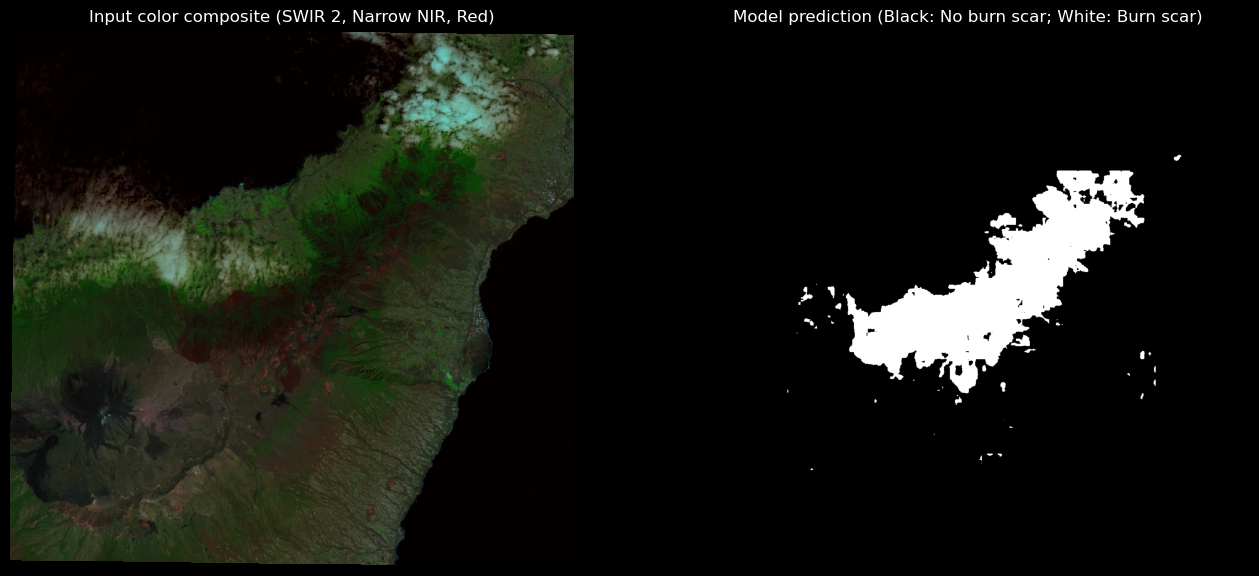

In [31]:
config_path = "../Prithvi/configs/burn_scars_Prithvi_100M_array.py"
ckpt = "../Prithvi/checkpoints/burn_scars_Prithvi_100M.pth"
bands = "[0,1,2,3,4,5]"
array = input_array[5:-5, 5:-5, :]

# Initialize ModelProcessor
model_processor = ModelProcessor(config_path, ckpt, bands)

# Get prediction
mask = model_processor.predict(array)


# Display input/output
model_processor.display_io(array, mask)


In [32]:
# Save io as PNGs
folder_path = '../data/processed/predictions'
region_name = 'Tenerife_now'
model_processor.save_io_as_png(array, mask, folder_path, region_name)

# Create animation
model_processor.create_animation(folder_path, region_name, output_format = 'gif')

Folder '../data/processed/predictions/Tenerife_now' already exists.


/home/iker/Vizzuality/Innovation/IBM-NASA-Model/hls-data-project/notebooks/../src/model_inference.py:120: RuntimeWarning: invalid value encountered in cast
  rgb_image = (rgb_image * 255).astype(np.uint8)


Processing: ffmpeg -framerate 1 -i ../data/processed/predictions/Tenerife_now/Tenerife_now_%03d.png -y ../data/processed/predictions/Tenerife_now/Tenerife_now.gif


ffmpeg version 5.1.2-3ubuntu1 Copyright (c) 2000-2022 the FFmpeg developers
  built with gcc 12 (Ubuntu 12.2.0-14ubuntu2)
  configuration: --prefix=/usr --extra-version=3ubuntu1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libglslang --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librist --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libsvtav1 --enable-libtheora --enable-libtwolame --enable-libvidstab -

Task created
Finished processing


frame=    2 fps=0.0 q=-0.0 Lsize=    1301kB time=00:00:01.01 bitrate=10555.8kbits/s speed=8.14x    
video:1301kB audio:0kB subtitle:0kB other streams:0kB global headers:0kB muxing overhead: 0.001501%
